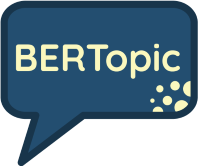

* BERTopic is a model that uses transformers to create topics. In short, it's topic modelling with BERT.

* Using a transformer-based language model already represents an advance to other topic modelling techniques, such as LDA and NMF, which extract topics based on the co-occurrence of words. It also outperforms models like Top2Vec because BERT is bidirectional, being able to generate more contextualized embeddings.

* Furthermore, BERTopic creates word clusters from a variation of the traditional TF-IDF, which the authors call class-based TF-IDF (c-TF-IDF). Instead of calculating the term frequency weighted by the term frequency in the documents, BERTopic converts each cluster into a single document (class) to calculate the TF-IDF. Thus, the set of words with the highest c-TF-IDF is highly representative of its cluster.


* See more in:

  [BERTopic GitHub](https://maartengr.github.io/BERTopic/index.html)

  [Grootendorst, M. (2022). BERTopic: Neural topic modeling with a class-based TF-IDF procedure.](https://arxiv.org/abs/2203.05794)


* For a comparison between LDA, NMF, Top2Vec and BERTopic, see:

  [Egger, R. and Yu, J. (2022). A Topic Modeling Comparison Between LDA, NMF, Top2Vec, and BERTopic to Demystify Twitter Posts.](https://www.frontiersin.org/articles/10.3389/fsoc.2022.886498/full)

# Installing and importing



In [1]:
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 3.4 MB/s eta 0:00:00
  Using cached plotly-5.13.0-py2.py3-none-any.whl (15.2 MB)
  Using cached umap_learn-0.5.3-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 18.2 MB/s eta 0:00:0000:0100:01
  Using cached hdbscan-0.8.29-cp310-cp310-macosx_11_0_arm64.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.33-py2.py3-none-any.whl (987 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 19.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 4.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 17.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 MB 13.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━

In [3]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
import pandas as pd

ContextualVersionConflict: (numpy 1.24.2 (/opt/homebrew/Caskroom/miniforge/base/envs/dsf/lib/python3.10/site-packages), Requirement.parse('numpy<1.24,>=1.18'), {'numba'})

# Reading documents
Our dataset will be the 3929 headlines of news stories about covid-19 published by the British newspaper The Guardian from January 1st to March 31st, 2020. The excel file also contains the full texts. Feel free to test BERTopic on them!

In [ ]:
df = pd.read_excel('./guardian_covid.xlsx')
df[:10]

In [ ]:
docs = df['headline']
docs[:10]

In [ ]:
timestamps = df['date']
timestamps[:10]

# Guided Topic Modeling
Here we will use the 5 steps suggested as default by BERTopic. But each step is customizable, so you can use whichever model you prefer.

In [ ]:
# Step 1 - Extract embeddings.
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality.
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings.
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics.
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation.
ctfidf_model = ClassTfidfTransformer()

topic_model = BERTopic(
    language='english', # Set to 'multilingual' for datasets with languages other than English.
    top_n_words=10,
    n_gram_range=(1, 1),
    min_topic_size=10,
    nr_topics=None,
    low_memory=False,
    calculate_probabilities=True, # The probabilities of all topics per document.
    diversity=None,
    seed_topic_list=None, # Like CorEx
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    ctfidf_model=ctfidf_model,
    verbose=False
)

topics, probs = topic_model.fit_transform(docs) # Fit the model and predict documents.

# Getting general information about the topics

In [ ]:
# A dataframe with all the generated topics.

info = topic_model.get_topic_info()
info

# -1 refers to outlliers and should typically be ignored.
# 'Count' is the number o documents on the topic.

In [ ]:
# A dataframe with general information about the topics.

get_document_info = topic_model.get_document_info(docs)
get_document_info[:10]

In [ ]:
# A dictionary with the top n terms per topic (default=10) and their respective c-TF-IDF values.

t = topic_model.topic_representations_
t

In [ ]:
# Accessing single topics (10 words by default).

topic_model.get_topic(0)

In [ ]:
# Getting the 3 most representative docs per topic.

topic_model.get_representative_docs(0)

In [ ]:
# Defining our own labels for each topic.
# TIP! When first looking at topics, be more descriptive and specific than general.

topic_labels = {-1: "Outlier", 0: "Understanding the disease", 1: "Impact on football events", 2: "Outbreak in China",
                3: "Outbreak in UK", 4:"Impact on education", 5: "Impact on supply", 6: "Economic consequences", 7: "Impact on NHS",
                8: "Social isolation", 9: "Impact on travel", 10: "Trump's measures", 11: "UK's measures", 12: "Outbreak in Italy",
                13: "Outbreak on cruises", 14: "Impact on cultural events", 15: "Impact on the workforce", 16: "Testing",
                17: "Outbreak in prisons", 18: "Boris Johnson's response", 19: "Outbreak in Australia", 20: "Morrison's measures",
                21: "Lockdown", 22: "Economic consequences", 23: "Evacuation from Wuhan", 24: "Impact on the Olympics",
                25: "Outbreak in New Zealand", 26: "Consequences on Australia's economy", 27: "Outbreak in New York", 28: "Outbreak in Europe", 29: "Lockdown",
                30: "Impact on elections", 31: "Outbreak in Wuhan", 32: "Impact on cultural events", 33: "Outbreak in Spain",
                34: "Rishi Sunak's economic response", 35: "Outbreak in South Korea", 36: "Outbreak in California", 37: "Hand sanitizer",
                38: "Ventilators", 39: "Masks", 40: "Outbreak in Middle East", 41: "Vulnerable groups", 42: "Impact on sports"
}

topic_model.set_topic_labels(topic_labels)

Here we can get the first insights into our corpus. The topics are apparently related to the following subjects:
- Efforts to understand and combat the new disease;
- The spread of the coronavirus around the world from Wuhan;
- Impacts on various sectors of society, such as the economy, education and sporting, artistic and cultural events;
- Monitoring and protection measures, such as testing, social isolation, hand sanitiser and masks.

These subjects seem to be quite consistent with our corpus, as it concerns the first 3 months of the outbreak of the new coronavirus.

# Visualisation

## Barchart
Visualise a barchart of selected topics.

In [ ]:
topic_model.visualize_barchart(topics=None, top_n_topics=8, n_words=10, custom_labels=True, width=250, height=350,)

## Intertopic Distance Map
Visualise topics, their sizes, and their corresponding words. You can hover over the figure to see the topics. The bar at the bottom of the figure highlights the topics.

In [ ]:
topic_model.visualize_topics()

# Documents in 2D
Visualise the documents of each topic in 2D. Hover over the figure to see the documents. To facilitate the visualisation, you can also select the topics to highlight them.

In [ ]:
topic_model.visualize_documents(docs, custom_labels=True, width=1000, height=750)

# Hierarchical Topics
Visualise a hierarchical structure of the topics.

In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(docs)
topic_model.visualize_hierarchy(custom_labels=True, width=1000, height=600, hierarchical_topics=hierarchical_topics, color_threshold=1.5)

# Heatmap
Visualise a heatmap of the topic's similarity matrix.

In [ ]:
topic_model.visualize_heatmap(custom_labels=True)

# Topic Probabilities per Document
Choose a document and see the probabilities of topics it may belong to.

In [ ]:
topic_model.visualize_distribution(probs[1], min_probability=0.015, custom_labels=True)

# Approximate Distribution
Visualise the topic distribution in a document, but on a token level. It indicates the extent to which a certain word belongs to a specific topic.

In [ ]:
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, calculate_tokens=True)

distr = topic_model.visualize_approximate_distribution(docs[20], topic_token_distr[20])
distr

# Topics Over Time
Visualise topics over time. Remember that you must have a dataset containing the documents' dates. Select the topics in the figure for better visualisation.

In [ ]:
topics_over_time = topic_model.topics_over_time(docs, timestamps)
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=5, custom_labels=True, width=1000, height=450)

# Querying Topics by Keywords
One interesting function of BERTopic is finding topics most similar to a search term. It creates an embedding for the keyword and compares that with the topic embeddings. The most similar topics are returned along with their similarity values. The search term can be of any size, but since it compares with the topic representation, it is advised to keep it below 5 words.

In [ ]:
topic_model.find_topics('fear', top_n=5)

# Functions query() and query_list() to get a summary of a given keyword or a set of keywords

## query() – to query a single keyword

In [ ]:
def query(keyword, n_topics, save_output=False):
  """
  -> From a given keyword, it creates a dataframe with the related topics and their representative documents.
  :keyword: the term you want to search
  :number: the number of topics related to the given keyword
  :save_output: save the dataframe as an excel file
  :return: dataframe
  """
  summary = []
  for b in range (0, (n_topics)):
      df = {}
      df['Keyword'] = keyword
      df['Topic_number'] = topic_model.find_topics(keyword, top_n=n_topics)[0][b]
      df['Score'] = topic_model.find_topics(keyword, top_n=n_topics)[1][b]
      df['Topic_label'] = topic_labels[df['Topic_number']]
      df['Words'] = []
      for c in range (0, 10):
          word = topic_model.get_topic(topic_model.find_topics(keyword, top_n=n_topics)[0][b])[c][0]
          df['Words'].append(word)
      df['Tf-idf'] = []
      for d in range (0, 10):
          tf_idf = topic_model.get_topic(topic_model.find_topics(keyword, top_n=n_topics)[0][b])[d][1]
          df['Tf-idf'].append(tf_idf)
      if df['Topic_number'] != -1: # When the topic is -1 (outlier), BERTopic doesn't give the documents.
          df['Rep_doc1'] = topic_model.get_representative_docs(topic_model.find_topics(keyword, top_n=n_topics)[0][b])[0]
          df['Rep_doc2'] = topic_model.get_representative_docs(topic_model.find_topics(keyword, top_n=n_topics)[0][b])[1]
          df['Rep_doc3'] = topic_model.get_representative_docs(topic_model.find_topics(keyword, top_n=n_topics)[0][b])[2]
          summary.append(df)
      else: # We must pass NULL values in case the topic is -1.
          df['Rep_doc1'] = 'NULL'
          df['Rep_doc2'] = 'NULL'
          df['Rep_doc3'] = 'NULL'
          summary.append(df)
      sum = pd.DataFrame(summary)
      if save_output:
          sum.to_excel('C:/Users/luiz_neves/Documents/summary.xlsx')
  return(sum)

In [ ]:
query('fear', 5, save_output=True)

## query_list() – to query a list of keywords

In [ ]:
def query_list(list_keywords, n_topics, save_output=False):
  """
  -> From a list of keywords, it creates a dataframe with the related topics and their representative documents.
  :list_keywords: the terms you want to search
  :n_topics: the number of topics related to the given list of keywords
  :save_output: save the dataframe as an excel file
  :return: dataframe
  """
  sum_list = pd.DataFrame()
  cont = 0
  for k in list_keywords:
      y = query(list_keywords[cont], n_topics)
      sum_list = pd.concat([sum_list, y])
      cont += 1
  if save_output:
      sum_list.to_excel('C:/Users/luiz_neves/Documents/summary_list.xlsx')
  return(sum_list)

In [ ]:
my_list = ['vaccine', 'science', 'fake news']

query_list(my_list, 5, save_output=True)

In [ ]:
pip install pySankey

In [ ]:
from pySankey import sankey

In [ ]:
summary_list = pd.read_excel('C:/Users/luiz_neves/Documents/summary_list.xlsx')
sankey.sankey(left=summary_list['Keyword'], right=summary_list['Topic_label'], leftWeight=summary_list['Score'], rightWeight=summary_list['Score'],
              aspect=20, fontsize=12)

# BONUS! Creating dataframes to organize the data

In [ ]:
# Creating a dataframe with the Topic Representations.
dict = topic_model.topic_representations_
df_general_info = pd.DataFrame(list(dict.items()), columns = ['topic', 'word_tf_idf'])

# Adding the column Topic Embeddings
df_general_info['embed'] = topic_model.topic_embeddings_

# The embeddings for each topic are calculated by taking the weighted average
# of word embeddings in a topic based on their c-TF-IDF values.

df_general_info

In [ ]:
# Creating a dataframe with the representative documents per topic.
dict2 = topic_model.representative_docs_
df_rep_docs = pd.DataFrame(list(dict2.items()), columns = ['topic', 'rep_docs'])
df_rep_docs

In [ ]:
# Creating a df with each topic and the three respective most representative documents.

topics_repdocs = []
for n in range(0, len(info)-1):
    new_df = {}
    new_df['topic'] = n
    new_df['doc1'] = topic_model.get_representative_docs(n)[0]
    new_df['doc2'] = topic_model.get_representative_docs(n)[1]
    new_df['doc3'] = topic_model.get_representative_docs(n)[2]
    topics_repdocs.append(new_df)

guar_topics_repdocs = pd.DataFrame(topics_repdocs)
guar_topics_repdocs

In [ ]:
# Creating a df with all the documents and their respective topic.

guar_doc_topic = pd.DataFrame({'document': docs, 'topic': topics})
guar_doc_topic